# Tarefa 3: Análise com ANOVA no Mercado Imobiliário!

Nesta atividade, vamos analisar dados de uma base de dados imobiliária muito conhecida, [Ames Housing Dataset](https://www.kaggle.com/prevek18/ames-housing-dataset). Por isso, antes de mais nada, vamos importá-la:

In [22]:
import kagglehub
import pandas as pd
from pathlib import Path

path = Path(kagglehub.dataset_download("prevek18/ames-housing-dataset"))
filename = next(path.glob('*'))
df = pd.read_csv(path / filename)

-----

### (a) Comparação de Preços entre Características:

> * Escolha três características das propriedades (por exemplo, número de quartos, tipo de bairro e condição da casa)
> * utilize a ANOVA para comparar o preço de venda médio entre diferentes níveis dessas características. 
>     * Por exemplo, você pode investigar se o preço médio de venda difere entre casas com e sem garagem, ou entre diferentes tipos de bairros.
> * Explique os resultados da ANOVA e interprete o que eles significam em termos de diferenças de preço.

Para esse exercício, vamos focar em diferenças de materiais de construção, apenas para ter um tema
comum.
Assim, vamos examinar as seguintes seguincolunas:


In [2]:
material_columns = ['Foundation', 'Exterior 1st', 'Mas Vnr Type', ]
factor_values_count = pd.DataFrame({
    'factor': material_columns,
    'possible_values': [len(df[c].unique()) for c in material_columns]
})
factor_values_count

,factor,possible_values
0,Foundation,6
1,Exterior 1st,16
2,Mas Vnr Type,5


Isto nos dá três hipóteses a testar:

* Teste 0 (fundação):
    * $H_{0,0}: $ a média do preço entre os diversos materiais de fundação é a mesma.
    * $H_{a,0}: $ casas com materiais de fundação diferente têm médias de preço diferentes.
* Teste 1 (paredes externas):
    * $H_{0,1}: $ a média do preço entre os diversos materiais das paredes externas é a mesma.
    * $H_{a,1}: $ casas com paredes externas de diferentes materias têm médias de preço diferentes.
* Teste 2 (revestimento de alvenaria):
    * $H_{0,2}: $ a média do preço entre os diversos revestimentos de alvenaria é a mesma.
    * $H_{a,2}: $ casas com diferentes tipos de revestimento de alvenaria têm médias de preço diferentes.

Vamos usar ANOVA para comparar os preços médios entre os grupos. Primeiro, a cobertura exterior:

In [3]:
import numpy as np
from scipy import stats

def anova(df, factor):
    # Clean up off missing values
    data = df[[factor, "SalePrice"]].dropna()
    groups = [group["SalePrice"].values for _, group in data.groupby(factor)]
    f_stat, p_val = stats.f_oneway(*groups)

    # Degrees of freedom
    k = len(groups)           # number of categories
    N = sum(len(g) for g in groups)  # total samples
    df_between = k - 1
    df_within = N - k
    return (
        factor,
        df_between,
        df_within,
        f_stat, 
        p_val
    )

# Show results
for col in material_columns:
    (
        factor,
        df_between,
        df_within,
        f_stat,
        p_value
    ) = anova(df, col)
    print(
        f"{factor}:\tF({df_between}, {df_within}) = "
        f"{f_stat:.3f}, p = {p_value:.3e}")

Foundation:	F(5, 2924) = 227.568, p = 1.267e-205
Exterior 1st:	F(15, 2914) = 39.741, p = 3.386e-106
Mas Vnr Type:	F(3, 1151) = 28.001, p = 1.770e-17


Esses valores são bem altos! Aparentemente, para todas essas características, há grupos que têm média muito diferente dos outros. Vamos examinar as estatísticas desses grupos.

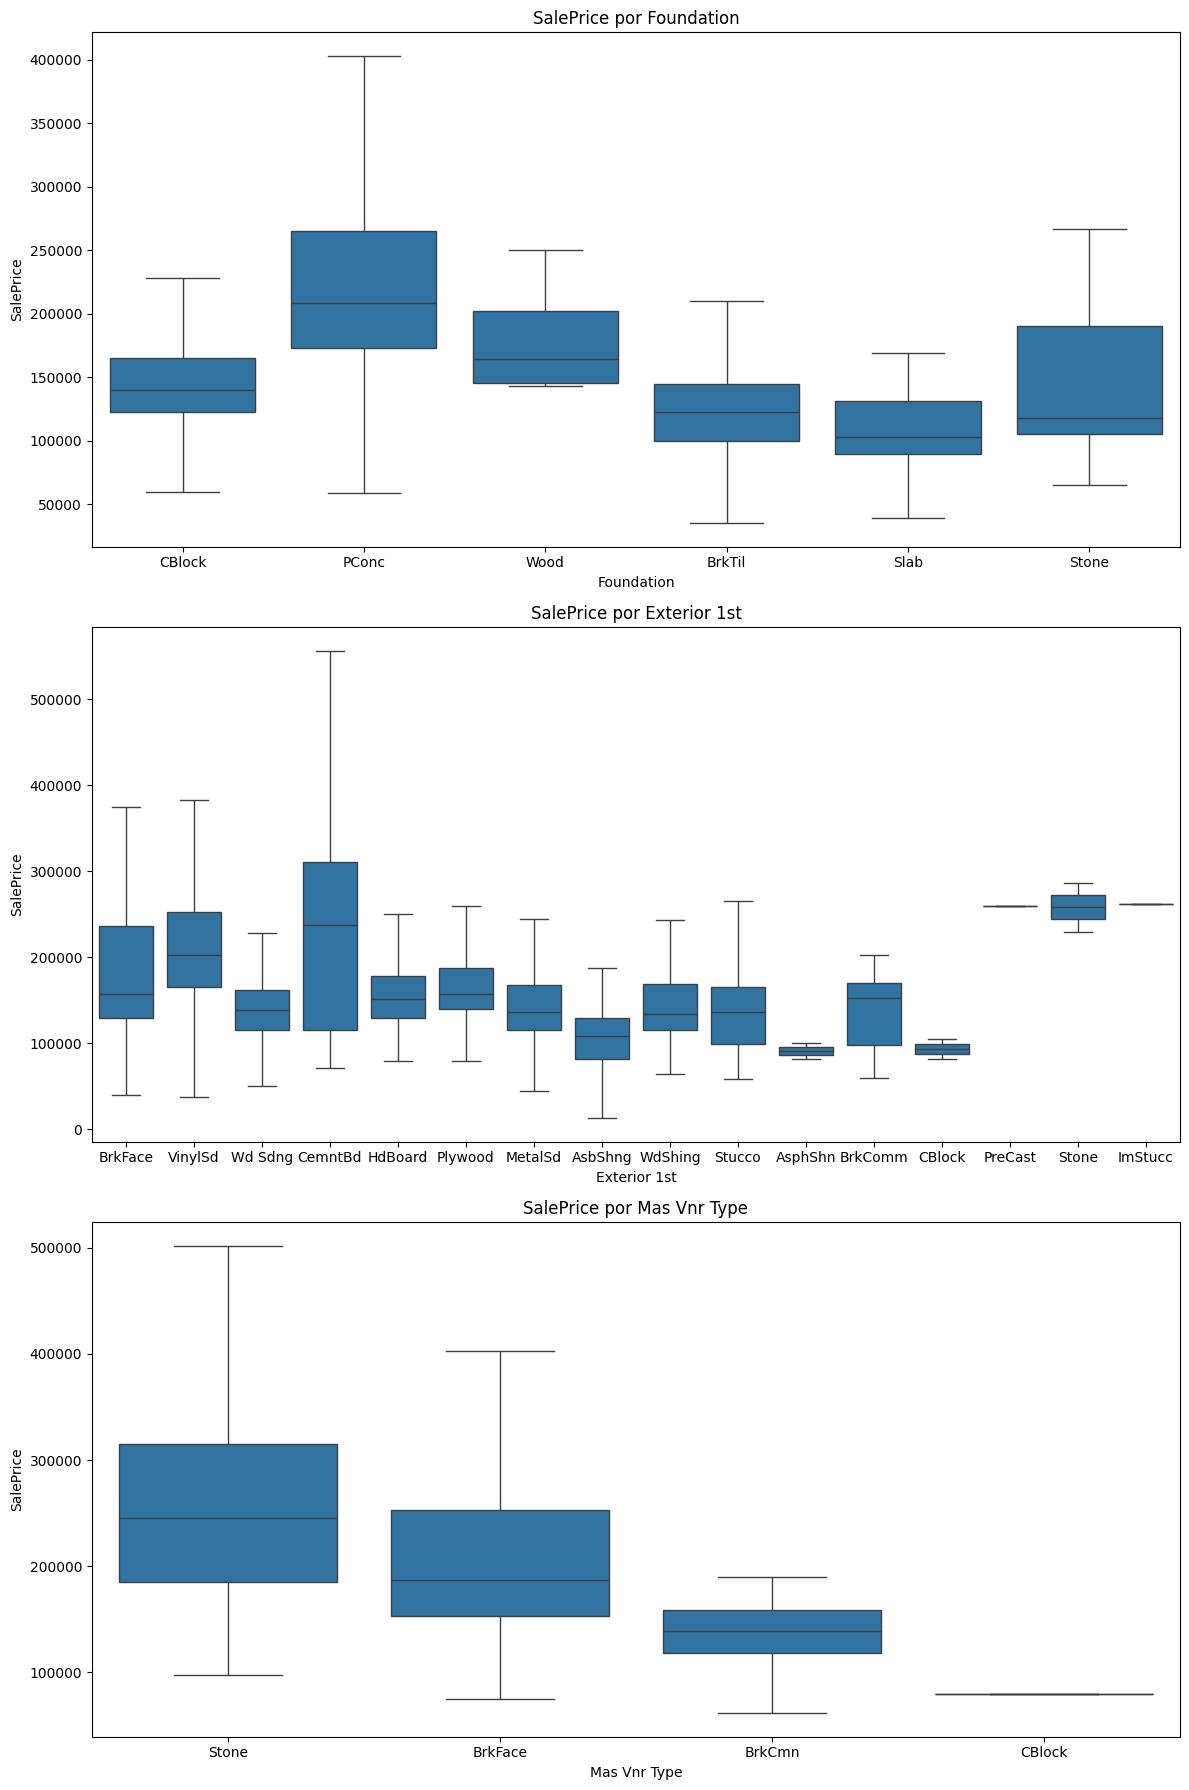

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

f, axes = plt.subplots(3, 1, figsize=(12, 18))

def add_box_subplot(axis, df, factor, value='SalePrice'):
    sns.boxplot(x=factor, y=value, data=df,  ax=axis,  showfliers=False)
    axis.set_title(f"{value} por {factor}")

add_box_subplot(axes[0], df, 'Foundation')
add_box_subplot(axes[1], df, 'Exterior 1st')
add_box_subplot(axes[2], df, 'Mas Vnr Type')


plt.tight_layout()
plt.show()

De fato, os gráficos mostram grande variação das médias dos grupos para todas as categorias escolhidas.

A conclusão é evidente: podemos rejeitar com alta confiança as hipóteses $H_{0,0}$, $H_{0,1}$ e $H_{0,2}$. Podemos dizer confortavelmente que o material da composição dos fundamentos, paredes e revestimentos das casas, afeta muito seu preço. Em especial, o material do fundamento é o que mais afeta.

Isso, claro, se os pré-requisitos de ANOVA se aplicarem a esses dados...

### (b) Validação dos Pressupostos da ANOVA

> * Realize os testes necessários para verificar se os pressupostos da ANOVA são atendidos para cada uma das características escolhidas.
> * Explique se
>    * a ANOVA tradicional é adequada ou
>    * se há necessidade de um método alternativo (por exemplo, ANOVA robusta ou testes não paramétricos),
>  * Justifice sua escolha com base nos pressupostos discutidos em aula :
>      * normalidade dos resíduos,
>      * homocedasticidade,
>      * independência dos erros.
>  * Se um método alternativo for necessário, realize o teste adequado e interprete os resultados.

#### Normalidade dos resíduos



Vamos fazer uns gráficos Q-Q dos erros para ter uma ideia visual. Primeiro, façamos para agrupamentos pelo material de fundação:

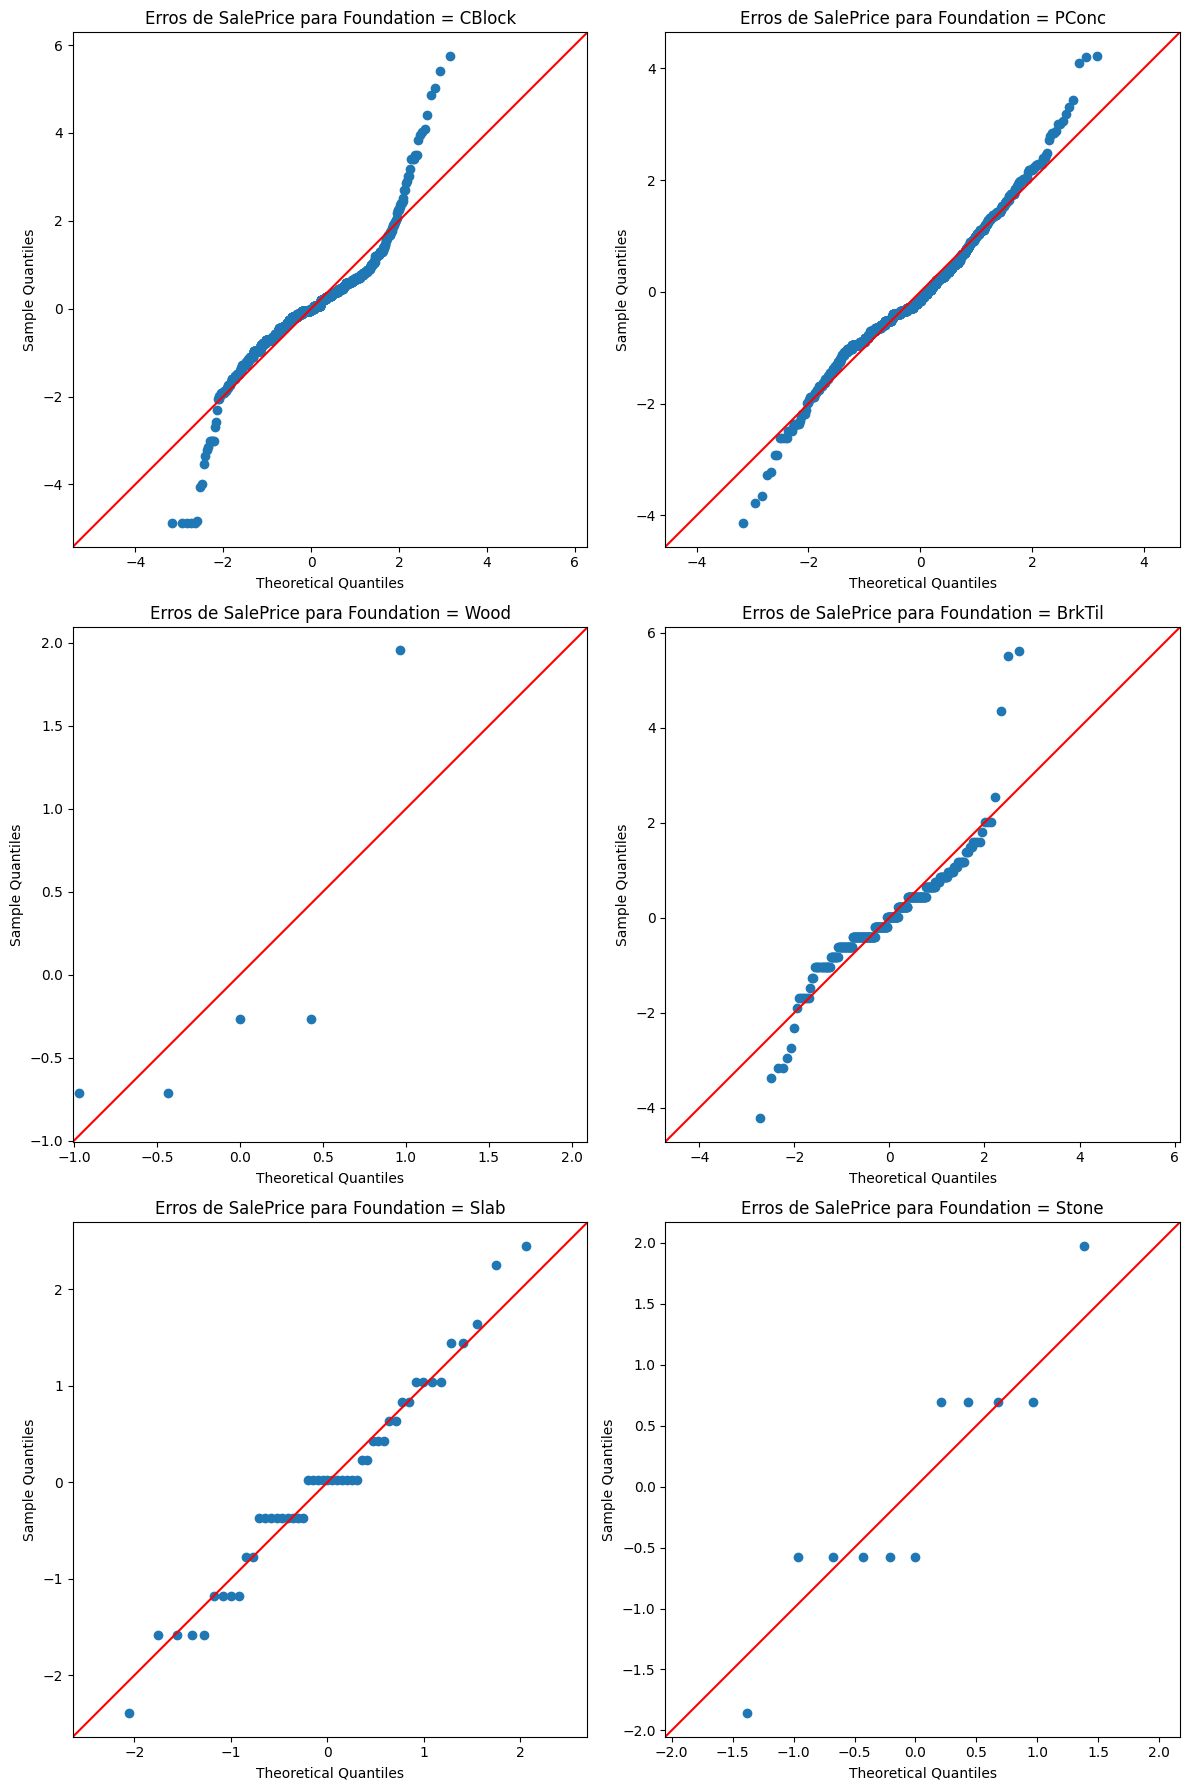

In [5]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import math

def get_residuals(df, factor=None, group=None, value='SalePrice'):
    """
    Get the residuals of regression. We are using OLS here.
    """
    #return df[value] - df[value].mean()

    if not factor:
        # I want the residuals of the entire population, but I don't have
        # a value to regress to, so to say, so I will
        # subtract it out:
        return df[value] - df[value].mean()
    
    subset = df[factor]==group if group else None
    model = ols(f'Q("{factor}") ~ C(Q("{value}"))', subset=subset, data=df).fit()
    return model.resid

def relevant_values(df, factor, threshold=2):
    """
    Returns all values a (discrete, enumerable) factor assumes,
    discarding the values that has less than 'threshold' values
    (since those usually offer little informantion for analysis).
    """
    factor_options = df[factor].unique()
    # Let's ignore excessively small partitions
    options_count = (
        (fo, len(df.loc[df[factor]==fo])) for fo in factor_options 
    )
    return [k for k, v in options_count if v > 2]

def qqplot(df, factor, value='SalePrice', cols=2, minimum_partition_size=2):
    factor_values = relevant_values(df, factor)
    rows = math.ceil(len(factor_values) / cols)
    f, axes = plt.subplots(rows, cols, figsize=(12, 6*rows))
    for i, fo in enumerate(factor_values):
        axis = axes[i//cols][i % cols]
        axis.set_title(f"Erros de SalePrice para {factor} = {fo}")
        residuals = get_residuals(df, factor, fo)
        sm.qqplot(residuals, line='45', fit=True, ax=axis)
    plt.tight_layout()
    plt.show()

qqplot(df, 'Foundation')

(Note que descartamos os grupos com muitos poucos indivíduos.)

Os erros não parecem normais em ao menos algumas das partições baseadas em material de fundação: CBlock, BrickTil e PConc. Isso já aciona um alarme. Vejamos como se comportam para o material de parede externa:

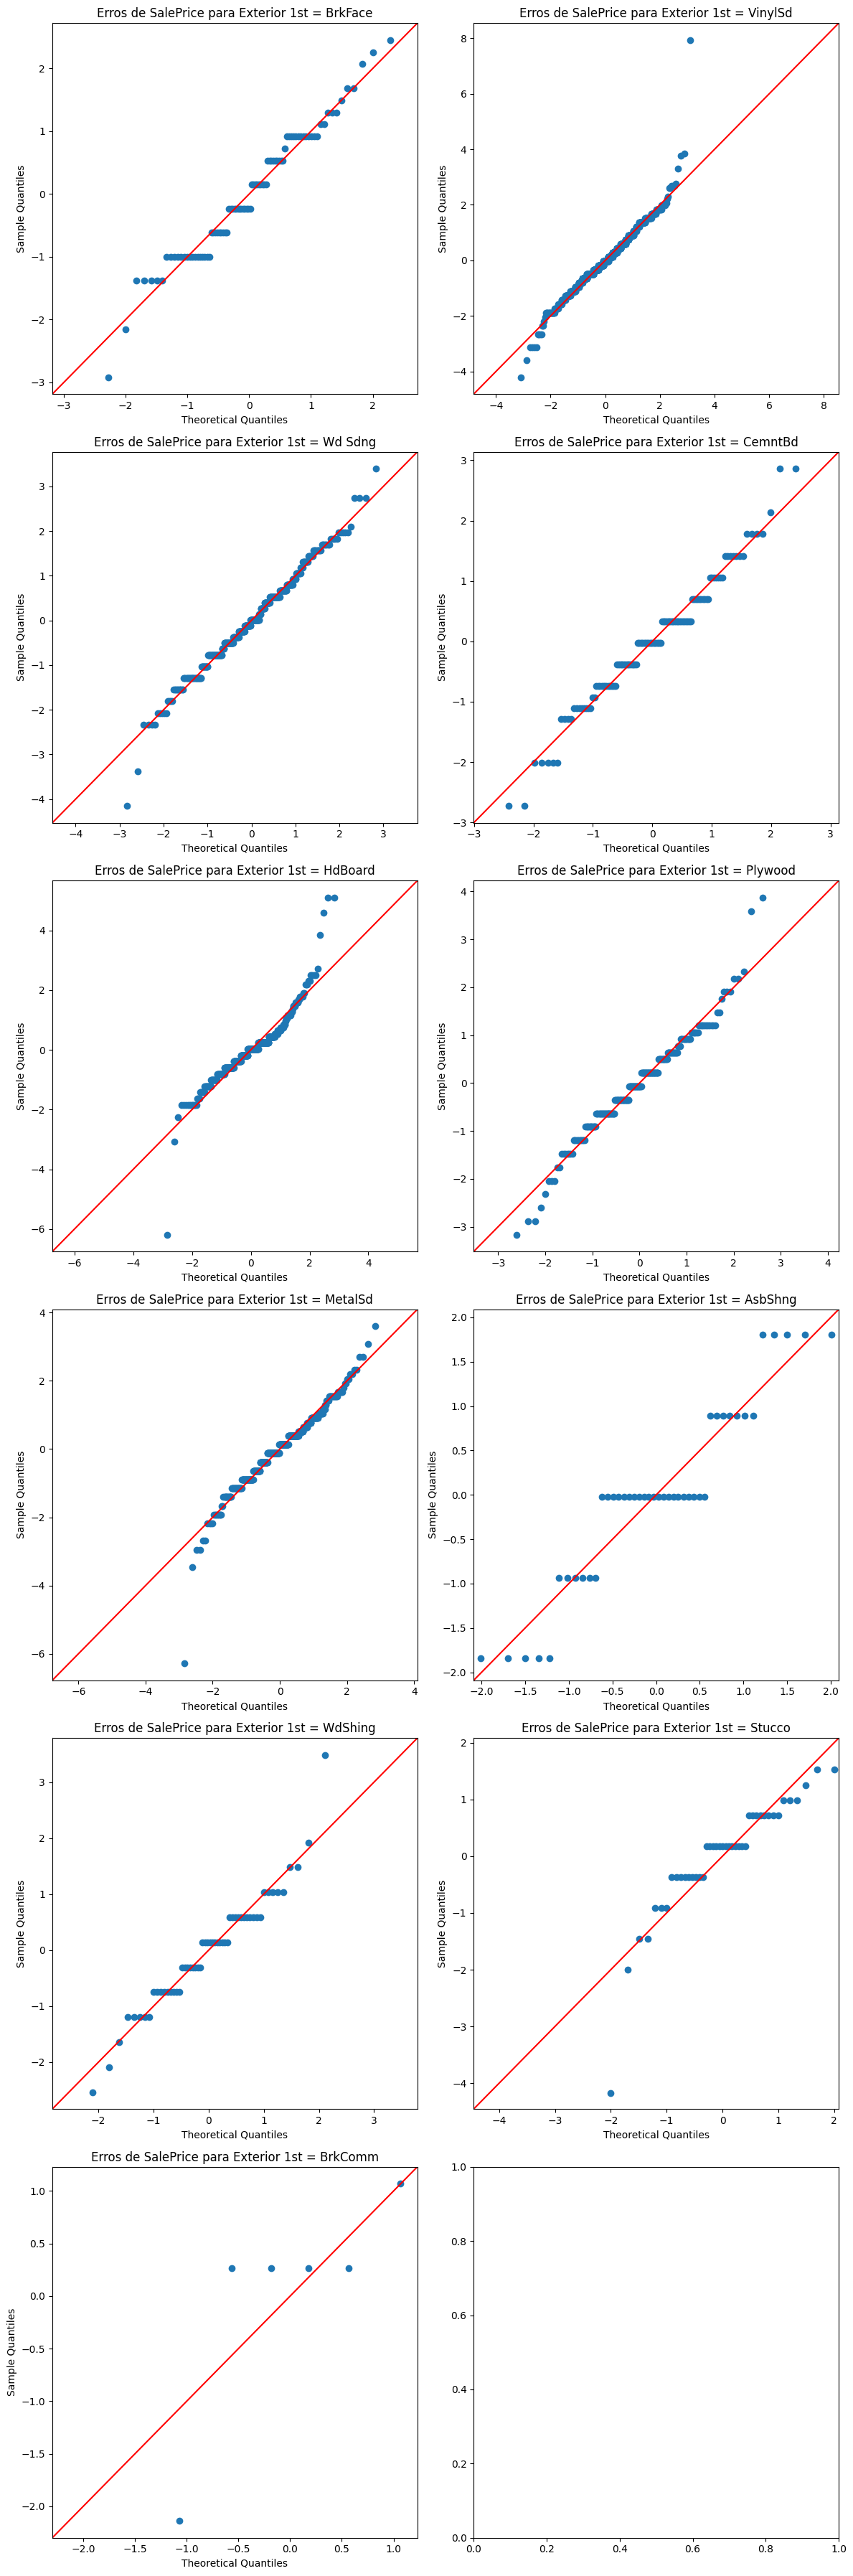

In [6]:
qqplot(df, 'Exterior 1st')

Para material de paredes, em algums casos temos tão poucos dados que é difícil avaliar, mas em outros claramente a normalidade não se confirma, como em SD Wng e HdBoard. Vejamos finalmente o efeito do revestimento externo nos erros:

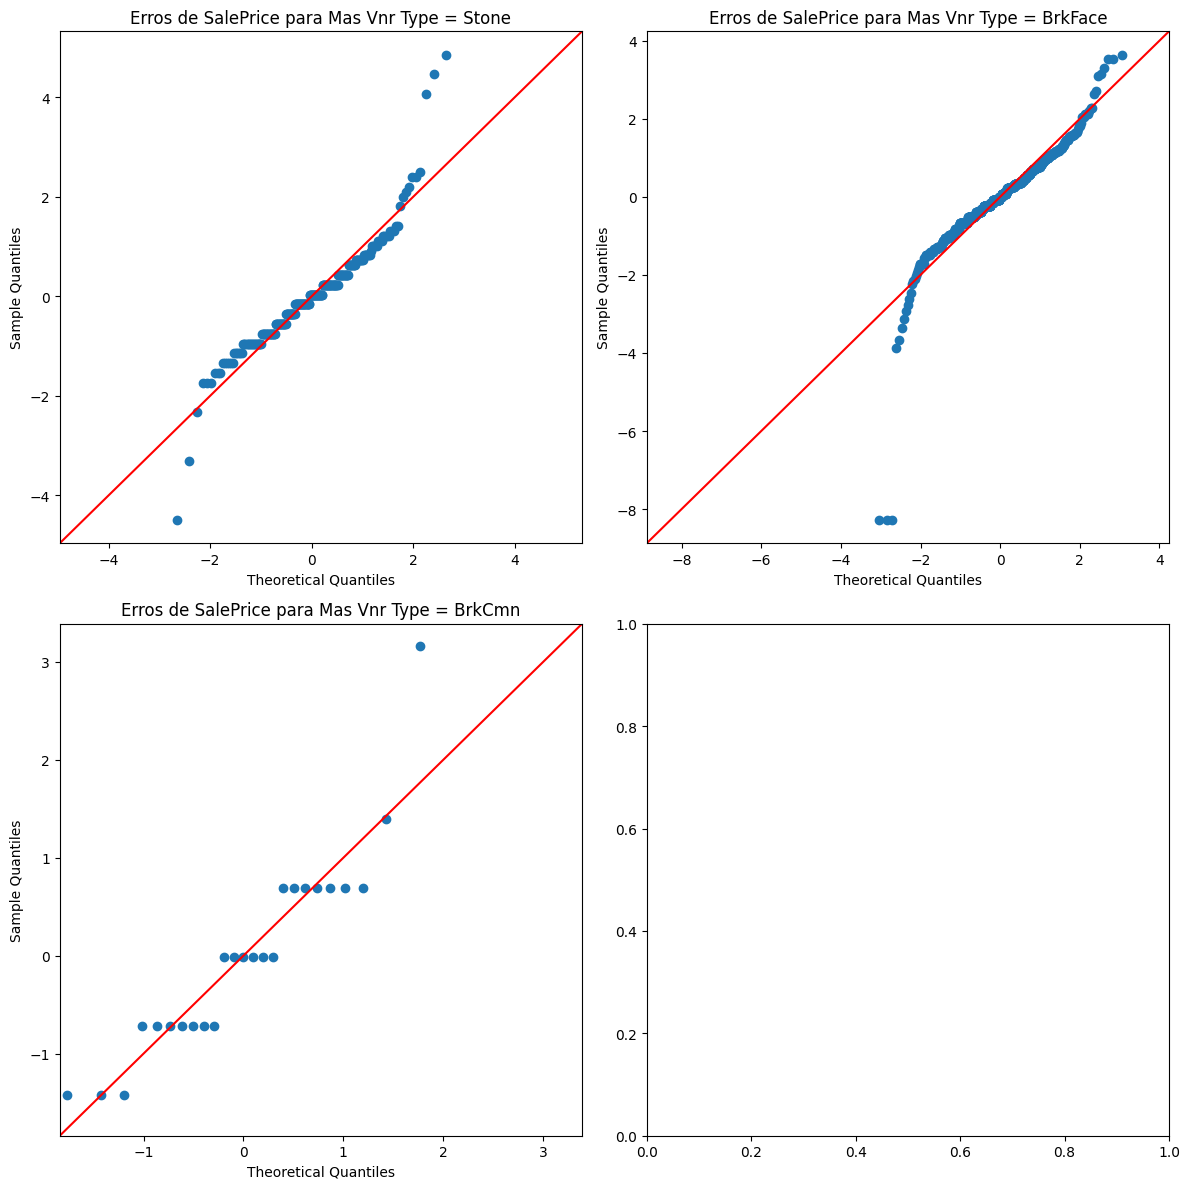

In [7]:
qqplot(df, 'Mas Vnr Type')

Não estamos muito confiantes de que os erros seguem uma distribuição normal... Vamos tirar a provacom o teste the Shapiro-Wilk. Novamente, agora para material de fundação:

In [8]:
from scipy.stats import shapiro

def run_shapiro_wilk(df, factor=None, group=None, value='SalePrice'):
    residuals = get_residuals(df, factor, group)
    return shapiro(residuals) + (len(residuals),)

def print_shapiro_wilk(df, factor=None, group=None, value='SalePrice'):
    stat, p_value, count = run_shapiro_wilk(df, factor, group, value)
    if group is None:
        group= 'Population'
    print(f"{group:>8}:\tW = {stat:.3}, \tp = {p_value:.3}, \tcount={count}")

def shapiro_wilk_group(df, factor, value='SaleRate'):
    print(f"Shapiro-Wilk statistic for {factor}")
    factor_options = relevant_values(df, factor)
    # Apply the test
    for fo in factor_options:
        print_shapiro_wilk(df, factor, fo)

shapiro_wilk_group(df, 'Foundation')

Shapiro-Wilk statistic for Foundation
  CBlock:	W = 0.896, 	p = 3.26e-28, 	count=1244
   PConc:	W = 0.979, 	p = 1.04e-12, 	count=1310
    Wood:	W = 0.71, 	p = 0.0121, 	count=5
  BrkTil:	W = 0.882, 	p = 1.02e-14, 	count=311
    Slab:	W = 0.976, 	p = 0.409, 	count=49
   Stone:	W = 0.893, 	p = 0.15, 	count=11


De fato, todos os resultados tiverem um p-valor minúsculo (bem abaixo de 0,05 por exemplo). Podemos confiantemente rejeitar a hipótese de que os resídulos seguem um processo normal.

Vejamos o mesmo para materiais de parede:

In [9]:
shapiro_wilk_group(df, 'Exterior 1st')

Shapiro-Wilk statistic for Exterior 1st
 BrkFace:	W = 0.972, 	p = 0.0555, 	count=88
 VinylSd:	W = 0.97, 	p = 7.62e-14, 	count=1026
 Wd Sdng:	W = 0.99, 	p = 0.0053, 	count=420
 CemntBd:	W = 0.978, 	p = 0.0373, 	count=126
 HdBoard:	W = 0.906, 	p = 6.69e-16, 	count=442
 Plywood:	W = 0.973, 	p = 0.000297, 	count=221
 MetalSd:	W = 0.963, 	p = 2.72e-09, 	count=450
 AsbShng:	W = 0.892, 	p = 0.00062, 	count=44
 WdShing:	W = 0.959, 	p = 0.052, 	count=56
  Stucco:	W = 0.855, 	p = 7e-05, 	count=43
 BrkComm:	W = 0.709, 	p = 0.00763, 	count=6


In [10]:
shapiro_wilk_group(df, 'Mas Vnr Type')

Shapiro-Wilk statistic for Mas Vnr Type
   Stone:	W = 0.915, 	p = 9.58e-11, 	count=249
 BrkFace:	W = 0.872, 	p = 3.46e-26, 	count=880
  BrkCmn:	W = 0.887, 	p = 0.00958, 	count=25


Podemos rejeitar a hipótese de que os erros seguem uma distribuição normal para todos os particionamentos que fizemos! Isso nos faz questionar se a população toda segue uma distribuição normal para os errors:

In [11]:
print_shapiro_wilk(df)

Population:	W = 0.876, 	p = 2.33e-43, 	count=2930


Como o baixo p-valor mostra, podemos confortavelmente rejeitar a hipótese de que nossa população tem erro normal. Isto sugere que, mesmo que utilizássemos outros fatores, ANOVA provavelmente não seria bem aplicável.

Para encontrar outras alternativas, porém, vamos verificar a variância dos erros. A heteroscedacidade também afeta as opções que temos, afinal.

#### Homoscedasticidade

ANOVA exige que a variância de todos os grupos seja a mesma. Vamos verificar se isso se aplica aos diversos particionamentos que escolhemos utilizando o [teste de Levene](https://en.wikipedia.org/wiki/Levene's_test).

In [12]:
from scipy.stats import levene

def print_levene(df, factor, value='SalePrice'):
    factor_options = relevant_values(df, factor)
    values = [
        df.loc[df[factor] == fo, value] for fo in factor_options
    ]
    stat, p = levene(*values)
    print(f"Levene's test for {factor}")
    print(f"W = {stat:.3}, p = {p_value:.3e}, count={len(df)}")

print_levene(df, 'Foundation')
print_levene(df, 'Exterior 1st')
print_levene(df, 'Mas Vnr Type')

Levene's test for Foundation
W = 55.3, p = 1.770e-17, count=2930
Levene's test for Exterior 1st
W = 25.3, p = 1.770e-17, count=2930
Levene's test for Mas Vnr Type
W = 11.4, p = 1.770e-17, count=2930


Novamente, com valores tão baixos, é razovel rejeitar a hipótese de que esses particionamentos possuem a mesma variância.

Dadas essas limitações, ANOVA provavelmente não serve pare analisar estes particionamentos. Podemos porém fazer comparações de médias com outras ferramentas. Vamos experimentar [ANOVA de Welch](https://www.statisticshowto.com/welchs-anova/):

In [13]:
from statsmodels.stats.oneway import anova_oneway

def print_welch_anova(df, factor, value='SalePrice'):
    # We select only rows from groups with enough data because
    # anova_oneway breaks with too little data. Go figure.
    factor_options = set(relevant_values(df, factor))
    df = df.loc[df[factor].isin(factor_options)]
    result = anova_oneway(
        df[value], 
        groups=df[factor], 
        use_var="unequal"
    )
    stat, p_value, = result
    df_between, df_within = result.df
    print(f"{factor:>8}:\t[W] F({df_between}, {df_within:.5}) \t= {stat:.5},\tp = {p_value:.3e}")

print_welch_anova(df, 'Foundation')
print_welch_anova(df, 'Exterior 1st')
print_welch_anova(df, 'Mas Vnr Type')

Foundation:	[W] F(5.0, 31.453) 	= 193.32,	p = 1.224e-22
Exterior 1st:	[W] F(10.0, 138.75) 	= 60.268,	p = 1.576e-45
Mas Vnr Type:	[W] F(2.0, 71.013) 	= 63.171,	p = 1.731e-16


Novamente, temos valores bem altos e com p-valores bem baixos. Consideramos evidente que a média dos particionamentos por esses valores é diferente.

### Explorando outros fatores

Uma pergunta natural é, que outros fatores seriam apropriados para ANOVA? Vamos rodar uns testes sobre todas as colunas para encontrar algumas de interesse. Primeiramennte, precisamos encontrar os tipos de colunas:

In [14]:
cell_types = df.map(type)
types_arrays = {c: cell_types.loc[df[c].notna(), c].unique() for c in df}

# Verify if any row still has multiple types after removing NaNs.
multiple_types = [v for v in types_arrays.values() if len(v) > 1]
if len(multiple_types) > 0:
    print('Warning: columns with multiple types', multiple_types)

types = {c: v[0] for c, v in types_arrays.items()}

set(types.values())

{float, int, str}

Caso sejam numéricas, vamos separá-las em cinco níveis; se forem string, vamos criar partições para cada valor.

Comecemos verificando se algumas das colunas satisfaz a normalidade dos resíduos para suas partições.

In [40]:
param_columns = df.columns.drop(['PID', 'Order', 'SalePrice'])

sw_results = pd.DataFrame({
    'factor': param_columns,
    'type': [types[pc] for pc in param_columns],
    'W': np.zeros(len(param_columns)),
    'p_value': np.zeros(len(param_columns))
})

levels = df.copy().drop(param_columns, axis=1)
for i, pc in enumerate(param_columns):
    if sw_results['type'].loc[i] == int or  sw_results['type'].loc[i] == float:
        start = df[pc].min()
        step = (df[pc].max() - start) / 5
        floor = np.trunc((df[pc]-start)/step)*step+start
        levels[pc] = floor
    else:
        levels[pc] = df[pc]

for i, pc in enumerate(param_columns):
    [run_shapiro_wilk(levels, pc) for pc in ['Exterior 1st']]

ValueError: endog has evaluated to an array with multiple columns that has shape (2930, 6). This occurs when the variable converted to endog is non-numeric (e.g., bool or str).

-----

In [16]:
materials_df[materials_df['Mas Vnr Type'].isna()]
sum(materials_df['Mas Vnr Type'].isna()), sum(materials_df['Mas Vnr Type'].notna())

NameError: name 'materials_df' is not defined

| Column Name        | Expanded / Human-Readable Form | Description |
|--------------------|--------------------------------|-------------|
| Order              | Order                          | Row number in dataset |
| PID                | Parcel ID                      | Unique property identifier |
| MS SubClass        | Building Class                 | Type of dwelling (e.g., 1-story, 2-story, duplex) |
| MS Zoning          | Zoning Classification          | Residential/commercial zoning designation |
| Lot Frontage       | Lot Frontage (feet)            | Linear feet of street connected to property |
| Lot Area           | Lot Area (sq ft)               | Total lot square footage |
| Street             | Street Type                    | Road access type (paved, gravel) |
| Alley              | Alley Access                   | Type of alley access (if any) |
| Lot Shape          | Lot Shape                      | Shape of lot (regular, irregular) |
| Land Contour       | Land Contour                   | Flatness/slope of property |
| Utilities          | Utilities Available            | Public utilities available |
| Lot Config         | Lot Configuration              | Position of lot relative to others (corner, inside, etc.) |
| Land Slope         | Land Slope                     | Slope of property |
| Neighborhood       | Neighborhood                   | Physical location within Ames |
| Condition 1        | Proximity to Main Road/Railroad| Primary condition |
| Condition 2        | Proximity (Secondary)          | Secondary condition if two are present |
| Bldg Type          | Building Type                  | Dwelling type (single-family, townhouse, etc.) |
| House Style        | House Style                    | Architectural style (1-story, 2-story, split-level) |
| Overall Qual       | Overall Quality                | Overall material/finish quality (rated 1–10) |
| Overall Cond       | Overall Condition              | Overall condition of the house (rated 1–10) |
| Year Built         | Year Built                     | Original construction year |
| Year Remod/Add     | Year Remodeled/Added           | Year remodeled or additional construction |
| Roof Style         | Roof Style                     | Type of roof (gable, hip, etc.) |
| Roof Matl          | Roof Material                  | Roof covering material |
| Exterior 1st       | Exterior Covering (Primary)    | Primary exterior material |
| Exterior 2nd       | Exterior Covering (Secondary)  | Secondary exterior material |
| Mas Vnr Type       | Masonry Veneer Type            | Type of masonry veneer |
| Mas Vnr Area       | Masonry Veneer Area (sq ft)    | Veneer square footage |
| Exter Qual         | Exterior Quality               | Quality of exterior materials |
| Exter Cond         | Exterior Condition             | Condition of exterior materials |
| Foundation         | Foundation Type                | Type of foundation (slab, basement, crawl space) |
| Bsmt Qual          | Basement Quality               | Height/quality of basement |
| Bsmt Cond          | Basement Condition             | General basement condition |
| Bsmt Exposure      | Basement Exposure              | Walkout/garden-level basement exposure |
| BsmtFin Type 1     | Basement Finish Type 1         | First type of finished basement area |
| BsmtFin SF 1       | Basement Finished SF 1         | Square footage of first finished basement area |
| BsmtFin Type 2     | Basement Finish Type 2         | Second type of finished basement area |
| BsmtFin SF 2       | Basement Finished SF 2         | Square footage of second finished basement area |
| Bsmt Unf SF        | Basement Unfinished SF         | Square footage of unfinished basement |
| Total Bsmt SF      | Total Basement SF              | Total basement square footage |
| Heating            | Heating Type                   | Type of heating system |
| Heating QC         | Heating Quality/Condition      | Heating quality and condition |
| Central Air        | Central Air Conditioning       | Central AC present (Y/N) |
| Electrical         | Electrical System              | Type of electrical system |
| 1st Flr SF         | First Floor Square Footage     | Area of first floor |
| 2nd Flr SF         | Second Floor Square Footage    | Area of second floor |
| Low Qual Fin SF    | Low Quality Finished SF        | Finished area with low quality |
| Gr Liv Area        | Above Ground Living Area SF    | Total living area above grade |
| Bsmt Full Bath     | Basement Full Bathrooms        | Number of full bathrooms in basement |
| Bsmt Half Bath     | Basement Half Bathrooms        | Number of half bathrooms in basement |
| Full Bath          | Full Bathrooms (Above Grade)   | Number of full bathrooms above ground |
| Half Bath          | Half Bathrooms (Above Grade)   | Number of half bathrooms above ground |
| Bedroom AbvGr      | Bedrooms Above Grade           | Number of bedrooms above ground |
| Kitchen AbvGr      | Kitchens Above Grade           | Number of kitchens above ground |
| Kitchen Qual       | Kitchen Quality                | Quality of kitchen |
| TotRms AbvGrd      | Total Rooms Above Grade        | Number of rooms (excluding bathrooms) |
| Functional         | Home Functionality Rating      | Home functionality (typical, minor, major issues) |
| Fireplaces         | Number of Fireplaces           | Count of fireplaces |
| Fireplace Qu       | Fireplace Quality              | Quality of fireplace(s) |
| Garage Type        | Garage Type                    | Type of garage (attached, detached, etc.) |
| Garage Yr Blt      | Garage Year Built              | Year the garage was built |
| Garage Finish      | Garage Finish                  | Interior finish of garage |
| Garage Cars        | Garage Capacity (Cars)         | Car capacity of garage |
| Garage Area        | Garage Area (sq ft)            | Garage square footage |
| Garage Qual        | Garage Quality                 | Garage quality |
| Garage Cond        | Garage Condition               | Garage condition |
| Paved Drive        | Paved Driveway                 | Driveway type (paved, gravel, dirt) |
| Wood Deck SF       | Wood Deck Area (sq ft)         | Size of wood deck |
| Open Porch SF      | Open Porch Area (sq ft)        | Size of open porch |
| Enclosed Porch     | Enclosed Porch Area (sq ft)    | Size of enclosed porch |
| 3Ssn Porch         | Three-Season Porch (sq ft)     | Size of 3-season porch |
| Screen Porch       | Screened Porch Area (sq ft)    | Size of screened porch |
| Pool Area          | Pool Area (sq ft)              | Size of pool area |
| Pool QC            | Pool Quality                   | Pool quality |
| Fence              | Fence Quality                  | Fence quality |
| Misc Feature       | Miscellaneous Feature          | Other features not covered (shed, elevator, etc.) |
| Misc Val           | Miscellaneous Value (\$)        | Value of misc feature |
| Mo Sold            | Month Sold                     | Month when sold |
| Yr Sold            | Year Sold                      | Year when sold |
| Sale Type          | Sale Type                      | Type of sale (normal, auction, etc.) |
| Sale Condition     | Sale Condition                 | Sale condition (normal, foreclosure, etc.) |
| SalePrice          | Sale Price (\$)                 | Final selling price |




In [ ]:
df